# Evaluate Agents

In this notebook, the four agents will be compared to each other as well as to various benchmarks, particularly the agent presented in "Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy."

## Import Libraries

In [1]:
from stable_baselines3 import PPO
from gymnasium.envs.registration import register
import sys 
from sb3_contrib import RecurrentPPO
import os
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import gymnasium as gym
import yfinance as yf
import os
import warnings
import matplotlib.dates as mdates
import empyrical
import colorcet as cc
from collections import defaultdict
from scipy.stats import kstest
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov, fix_nonpositive_semidefinite
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation
from cvxpy import ECOS

In [2]:
# Add current path to system path
sys.path.append('/Applications/Studium/Master/Masterarbeit/AADRL/')

# Supress future warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from train_agents.util_functions import evaluate_policy, run_policy

## Define Constants and Load Data

In [3]:
# Load the testing data
testing_data = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/testing/market_data.csv',
                           index_col=0,header=[0,1])
turbulence_testing = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/testing/turbulence_index.csv',
                                 index_col=0)

# Load the training data 
training_data = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/training/market_data.csv',
                           index_col=0,header=[0,1])
turbulence_training = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/training/turbulence_index.csv',
                                  index_col=0)

# Load the validation data (needed for calculation of tangency and minimum variance portfolio)
validation_data = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/validation/market_data.csv',
                              index_col=0,header=[0,1])
turbulence_validation = pd.read_csv(r'/Applications/Studium/Master/Masterarbeit/AADRL/data/validation/turbulence_index.csv',
                                    index_col=0)

In [4]:
# Register the environment as a gym environment
register(
    id="Trading-v4", 
    entry_point="env.multistock_trading_v4:MultiStockTrading"
    )

In [5]:
N_EPISODE_VAL         = 10                                         # Number of episodes to do every N_STEP_VAL steps
N_STEP_SHARPE         = 299                                        # From the hyperparameter estimation
CONSIDER_SENTIMENTS   = [False, True, True, True]                  # Whether to consider sentiments for the different agents
CONSIDER_SHARPES      = [None, None, N_STEP_SHARPE, N_STEP_SHARPE] # Whether to consider sharpe ratio into reward function
SEEDS                 = [42, 7, 25, 14]                            # Random seeds used in training (needed to read the models)
NUM_AGENTS            = 4                                          # How many agents were trained
NUM_STEPS_TRAINING    = int(5e5)                                   # Number of steps executed during training 
N_STEP_SAVING         = 1e4                                        # After how many steps the model were saved during training
NUMBER_SAVED_MODELS   = int(NUM_STEPS_TRAINING//N_STEP_SAVING + 1) # Add 1 because first model (step 0) was also 
NUM_TRADING_DAYS      = 252                                        # Number of trading days, needed for annualization


In [6]:
# Create a list containing the numbers of saved models 
nums_saved_models = [i for i in range(0,int(NUM_STEPS_TRAINING)+int(N_STEP_SAVING),int(N_STEP_SAVING))]

## Comparison of the Trading Strategies (Agents, Ensemble Agent, Dow Jones, S&P5000, ...)

In [7]:
# Define a numpy array which contains the mean asset value for each agent using different seeds
mean_asset_value_best_agent = np.zeros(shape=(4,len(SEEDS),len(testing_data))) # Agent, Seed, Portfolio Value over the testing data 

# Loop overt the seeds
for idx_seed, seed in enumerate(SEEDS):
    # Loop over the different agents
    for agent_num, (consider_sentiment, consider_sharpe) in enumerate(zip(CONSIDER_SENTIMENTS, CONSIDER_SHARPES)):
        
        # Define the path to the corresponding agent
        best_model_path = f'/Applications/Studium/Master/Masterarbeit/AADRL/train_agents/training_eval/agent_{agent_num+1}_seed_{seed}/best_model.zip'

        # Define the test env
        test_env = gym.make(
                        'Trading-v4', 
                        market_data=testing_data, 
                        turbulence_index=turbulence_testing,
                        consider_sentiments=consider_sentiment, 
                        n_step_sharpe=consider_sharpe,
                    )
        
        # Load the model (unless it is the fourth agent, we need to load the PPO model)
        if agent_num != 3:
            agent = PPO.load(best_model_path, env=test_env)
        else:
            agent = RecurrentPPO.load(best_model_path,env=test_env)
        
        # Evaluate policy on test dataset (run each policy 3 times)
        asset_memory, _, _, _, _ = evaluate_policy(
                                                    test_env, 
                                                    agent,
                                                    n_eval_episodes=3,
                                                    deterministic=False
                                                    )
        
        # Take mean asset memory over the runs and save the mean asset memory
        # Note that asset memory has the shape (num_episodes, length_episode) -> mean regarding axis=0
        asset_memory = np.array(asset_memory).mean(axis=0)   
        mean_asset_value_best_agent[agent_num,idx_seed,:] = asset_memory


In [8]:
# Calculate the mean and std over the cumulative return for each agent and seed
cum_returns_best_agents = mean_asset_value_best_agent/mean_asset_value_best_agent[:,:,0][:,:,np.newaxis] - 1

# Take the mean and std over the different seeds 
mean_cum_returns_best_agents = cum_returns_best_agents.mean(axis = 1)
std_cum_returns_best_agents = cum_returns_best_agents.std(axis = 1)

In [9]:
# Calculate the mean and std over the assets at timestep t for the different seeds
agent_asset_values_mean = mean_asset_value_best_agent.mean(axis=1)
agent_asset_values_std = mean_asset_value_best_agent.std(axis=1)

### Dow Jones Data

In [10]:
#Benchmark DJI
dji =yf.download('^DJI',start='2016-01-01',end='2020-06-13')
closes_dji = dji['Adj Close']

# Calculate the cumulative returns
initial_val_dji = closes_dji[0]
cum_returns_dji = closes_dji/initial_val_dji - 1

[*********************100%%**********************]  1 of 1 completed


### S&P 500 Data

In [11]:
#Benchmark S&P 500
sp500 =yf.download('^GSPC',start='2016-01-01',end='2020-06-13')
closes_sp500 = sp500['Adj Close']

# Calculate the cumulative returns
initial_val_sp500 = closes_sp500[0]
cum_returns_sp500 = closes_sp500/initial_val_sp500 - 1

[*********************100%%**********************]  1 of 1 completed


### Ensemble Strategy Agent Data

In [12]:
# Load the asset histories for the different seeds
ensemble_agent_history = pd.read_csv(
                            r'/Applications/Studium/Master/Masterarbeit/AADRL/Ensemble_Strategy/evaluation (own)/ensemble_strategy_results.csv',
                            index_col=0)

In [13]:
# Take history only until 2020-06-12 to have the same time window as index and own agent
ensemble_agent_history = ensemble_agent_history.iloc[ensemble_agent_history.index <= '2020-06-12']

In [14]:
# Calculate the cumulative returns
initial_value_ensemble = ensemble_agent_history.iloc[0]
cum_returns_ensemble = ensemble_agent_history/initial_value_ensemble - 1

In [15]:
# Calculate mean cum return and standard deviation over the different seeds
mean_cum_returns_ensemble = cum_returns_ensemble.mean(axis=1)
std_cum_returns_ensemble = cum_returns_ensemble.std(axis=1)

In [16]:
# Calculate mean asset history
mean_asset_history_ensemble_agent = ensemble_agent_history.mean(axis=1)

### Minimum Variance Portfolio and Tangency Portfolio

At first, the MVP and TP need to be calculated based on the historic price data. For this, the library 'PyPortfolioOpt' (Martin, R. A., (2021). PyPortfolioOpt: portfolio optimization in Python. Journal of Open Source Software, 6(61), 3066, https://doi.org/10.21105/joss.03066) will be used. The approach is the following:
- Calibrate the weights of each asset within the MVP and TP based on the training and validation data
- Because the weights would lead to partial shares, the weights will be converted in such a way that the agent would need to buy whole stocks. 

#### Efficiency Frontier Plot

In [17]:
# Define the dataset containing the prices
market_data = pd.concat([training_data, validation_data])
df = market_data['Adj Close']

Investment will be over the testing data (1119 days; including the first day). In Markowitz Portfolio Theory, we need to define the expected return and the variance over the period of investment. To get that, we will use historic data (trainig & validation) and calculate the period returns. 

We use the following approach: 
    1) Calculate the period return from t_0 to t_0 + 1119 
    2) Shift t_0 by 1 until the end of the dataframe is hit

With this approach, multiple estimates for the period return will be generated.

In [18]:
# Calculate the period returns 
period_returns = df.pct_change(
                            len(testing_data) - 1
                            ).dropna()

In [19]:
# Calculate the expectation, variance and the covariance matrix
period_returns_mean_estimator = period_returns.mean(axis=0)
period_returns_std_estimator = period_returns.std(axis=0,ddof=1)
period_returns_covmat_estimator = period_returns.cov(ddof=1)

# Define risk free rate (default 0 - as in the other analyses) 
rf = 0

In [20]:
# Set the mean and covariance matrix (for the further calculation)
mu = period_returns_mean_estimator 
S = period_returns_covmat_estimator

In [23]:
# Define the efficient frontier object (weights are by default not negative)
ef = EfficientFrontier(mu, S, solver = ECOS)

# Calculate the risk of each stock
stds_stocks = np.sqrt(np.diag(ef.cov_matrix))

# Find the tangency portfolio
ef_tangency = ef.deepcopy()
tangecy_pf = ef_tangency.max_sharpe(risk_free_rate=rf)
ret_tangent, std_tangent, _ = ef_tangency.portfolio_performance(risk_free_rate=rf)

# Find the minimum variance portfolio
ef_mvp = ef.deepcopy()
mvp_pf = ef_mvp.min_volatility()
ret_mvp, std_mvp, _ = ef_mvp.portfolio_performance(risk_free_rate=rf)

# Generate random portfolios and calculate the return and risk of those
np.random.seed(1)
n_samples = 5000
weights = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = np.sum(ef.expected_returns * weights,axis=1)
stds =  np.sqrt(np.sum(weights @ ef.cov_matrix * weights,axis=1))

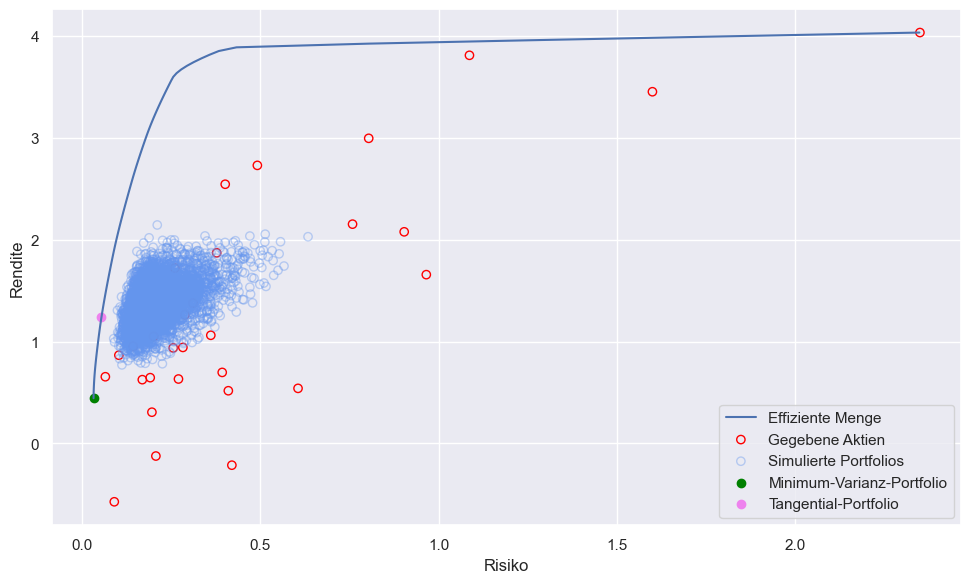

In [24]:
# Create a subplot
fig, ax = plt.subplots(figsize=(10,6));
sns.set_theme()

# Plot the efficient frontier and the assets into a risk return diagram
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
ax.scatter(stds_stocks,ef.expected_returns,facecolors='none', edgecolors='red',label='Gegebene Aktien')

# Add tangeny and simulated portfolios
ax.scatter(stds, rets,label='Simulierte Portfolios',alpha=0.4,facecolors='none', edgecolors='cornflowerblue')
ax.scatter(std_mvp, ret_mvp, c="green", label="Minimum-Varianz-Portfolio")
ax.scatter(std_tangent, ret_tangent, c="violet", label="Tangential-Portfolio")

legend = plt.legend()

# Get the labels and translate efficient frontier to german
for text in legend.get_texts():
    if text.get_text() == 'Efficient frontier':
        text.set_text('Effiziente Menge')

# Adjustments of the labels
ax.set_xlabel('Risiko')
ax.set_ylabel('Rendite');

#### Portfolioallocation

In [25]:
# Weights of each stock
print('Weights Tangency Portfolio',ef_tangency.clean_weights())
print('Weights Minimum Variance Portfolio',ef_mvp.clean_weights())

Weights Tangency Portfolio OrderedDict([('MRK', 0.0), ('MS', 0.0), ('MU', 0.0), ('NVDA', 0.0), ('M', 0.0), ('EBAY', 0.0), ('NFLX', 0.01546), ('GILD', 0.01225), ('VZ', 0.11724), ('DAL', 0.02156), ('JNJ', 0.0), ('QCOM', 0.0), ('KO', 0.02924), ('ORCL', 0.0), ('FDX', 0.0), ('HD', 0.0), ('WFC', 0.0), ('BMY', 0.0), ('LLY', 0.19686), ('CMG', 0.02317), ('CAT', 0.0), ('FSLR', 0.0), ('NOK', 0.0), ('LMT', 0.17012), ('MCD', 0.20333), ('MA', 0.0), ('EA', 0.0), ('FCX', 0.0), ('GPS', 0.0), ('PEP', 0.21077)])
Weights Minimum Variance Portfolio OrderedDict([('MRK', 0.06407), ('MS', 0.0), ('MU', 0.0), ('NVDA', 0.0), ('M', 0.00561), ('EBAY', 0.0), ('NFLX', 0.0), ('GILD', 0.0), ('VZ', 0.0), ('DAL', 0.00114), ('JNJ', 0.0), ('QCOM', 0.0), ('KO', 0.04012), ('ORCL', 0.0), ('FDX', 0.0), ('HD', 0.0), ('WFC', 0.0), ('BMY', 0.0), ('LLY', 0.0973), ('CMG', 0.0), ('CAT', 0.0), ('FSLR', 0.30802), ('NOK', 0.0), ('LMT', 0.05684), ('MCD', 0.18294), ('MA', 0.0), ('EA', 0.0), ('FCX', 0.0), ('GPS', 0.00101), ('PEP', 0.2429

Previous weights lead to partial shares -> get the absolut number of shares to buy using another optimization (lp) see: https://pyportfolioopt.readthedocs.io/en/latest/Postprocessing.html#post-processing. Weights are calibrated on training & validation dataset, but allocation is based on the first trading day!  

In [26]:
# Get the prices on the first trading day
prices = testing_data['Adj Close'].iloc[0] 

# Take transaction fees into consideration (to have a better comparison with the agent)
prices = prices * (1+0.001)

In [27]:
# Adjusted Allocation for the tangency portfolio
da_tp = DiscreteAllocation(tangecy_pf, prices, total_portfolio_value=int(1e6))
allocation_tp, leftover_tp = da_tp.lp_portfolio(solver='SCIPY')
print('Allocation-Tangency: ',allocation_tp, ' Leftover Tangency: ', leftover_tp)

Allocation-Tangency:  {'NFLX': 140, 'GILD': 167, 'VZ': 3900, 'DAL': 491, 'KO': 896, 'LLY': 2788, 'CMG': 52, 'LMT': 993, 'MCD': 2114, 'PEP': 2705}  Leftover Tangency:  2.3430088425520808


In [28]:
# Adjusted Allocation for the minimum variance portfolio
da_mvp = DiscreteAllocation(mvp_pf, prices, total_portfolio_value=int(1e6))
allocation_mvp, leftover_mvp = da_mvp.lp_portfolio(solver='SCIPY')
print('Allocation-MVP: ',allocation_mvp, ' Leftover MVP: ', leftover_mvp)

Allocation-MVP:  {'MRK': 1644, 'M': 224, 'DAL': 26, 'KO': 1229, 'LLY': 1378, 'FSLR': 4612, 'LMT': 332, 'MCD': 1902, 'GPS': 53, 'PEP': 3119}  Leftover MVP:  4.532595152035356


In [29]:
# Prices investment
prices_first_day = testing_data['Adj Close'].iloc[0] 

# Get the total investment into each stock for the different portfolios
investment_tp = (prices_first_day[allocation_tp.keys()] * list(allocation_tp.values())).sort_index()
investment_mvp = (prices_first_day[allocation_mvp.keys()] * list(allocation_mvp.values())).sort_index()

In [30]:
# Aggregate small positions
investment_mvp_wo_small_pos = investment_mvp[investment_mvp/investment_mvp.sum()*100 >= 2]
investment_mvp_wo_small_pos['Sonstige'] = investment_mvp[investment_mvp/investment_mvp.sum()*100 < 2].sum()

In [31]:
# Aggregate small positions
investment_tp_wo_small_pos = investment_tp[investment_tp/investment_tp.sum()*100 >= 2]
investment_tp_wo_small_pos['Sonstige'] = investment_tp[investment_tp/investment_tp.sum()*100 < 2].sum()

In [32]:
# Create colormap for the following pie chart (so that stocks have the same color also
# in different plots)
keys = list(market_data['Adj Close'].columns)

# Define the colormap
palette = sns.color_palette(cc.glasbey_light, n_colors=30) 

# Generate a color for each key
colors = {key: palette[i] for i, key in enumerate(keys)}

# Create color lists for each pie chart based on the keys
colors_tp = [colors[key] if key in colors.keys() else (0.1,0.4,0.8) for key in investment_tp_wo_small_pos.keys()]
colors_mvp = [colors[key] if key in colors.keys() else (0.1,0.4,0.8) for key in investment_mvp_wo_small_pos.keys()]

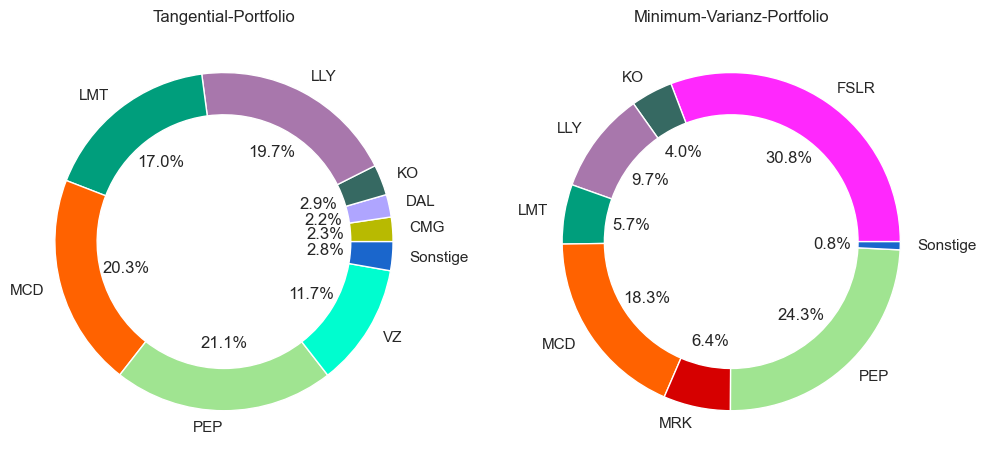

In [33]:
# Create subplots
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,15))
width_pie = 0.25

# Pie Chart for tangency portfolio
ax[0].pie(
        investment_tp_wo_small_pos, 
        labels=investment_tp_wo_small_pos.keys(), 
        autopct='%1.1f%%',
        wedgeprops=dict(width=width_pie, edgecolor='w'),
        colors=colors_tp,
        )
ax[0].set_title('Tangential-Portfolio')


# Pie Chart for minimum variance portfolio
ax[1].pie(
        investment_mvp_wo_small_pos, 
        labels=investment_mvp_wo_small_pos.keys(), 
        autopct='%1.1f%%',
        wedgeprops=dict(width=width_pie, edgecolor='w'),
        colors=colors_mvp
        )
ax[1].set_title('Minimum-Varianz-Portfolio');

In [34]:
# Check that the new weights are in fact different than before
investment_tp/investment_tp.sum() 

# Compare these weights with the one calculated above (e.g. before it was CMG: 0.02317. Now it it 0.023362)

CMG     0.023362
DAL     0.021537
GILD    0.012200
KO      0.029231
LLY     0.196850
LMT     0.170158
MCD     0.203274
NFLX    0.015410
PEP     0.210730
VZ      0.117249
Name: 2016-01-04, dtype: float64

#### Trading

In [35]:
# Multiply prices with initial number of bought shares (start from first day)
price_devlopment_tp = testing_data['Adj Close'].iloc[1:][allocation_tp.keys()] * np.array(list(allocation_tp.values()))

# Calculate portfolio value
price_devlopment_tp_total = price_devlopment_tp.sum(axis=1) + leftover_tp

# Add the 1 million at on the first day 
price_devlopment_tp_total = pd.concat([pd.Series(1e6,index=['2016-01-04']),price_devlopment_tp_total])

# Calculate cumulative returns
cum_returns_tp = price_devlopment_tp_total/price_devlopment_tp_total[0]-1

In [36]:
# Multiply prices with initial number of bought shares (start from first day)
price_devlopment_mvp = testing_data['Adj Close'].iloc[1:][allocation_mvp.keys()] * np.array(list(allocation_mvp.values()))

# Calculate portfolio value
price_devlopment_mvp_total = price_devlopment_mvp.sum(axis=1) + leftover_mvp

# Add the 1 million at on the first day 
price_devlopment_mvp_total = pd.concat([pd.Series(1e6,index=['2016-01-04']),price_devlopment_mvp_total])

# Calculate cumulative returns
cum_returns_mvp = price_devlopment_mvp_total/price_devlopment_mvp_total[0]-1

### Performance Plot

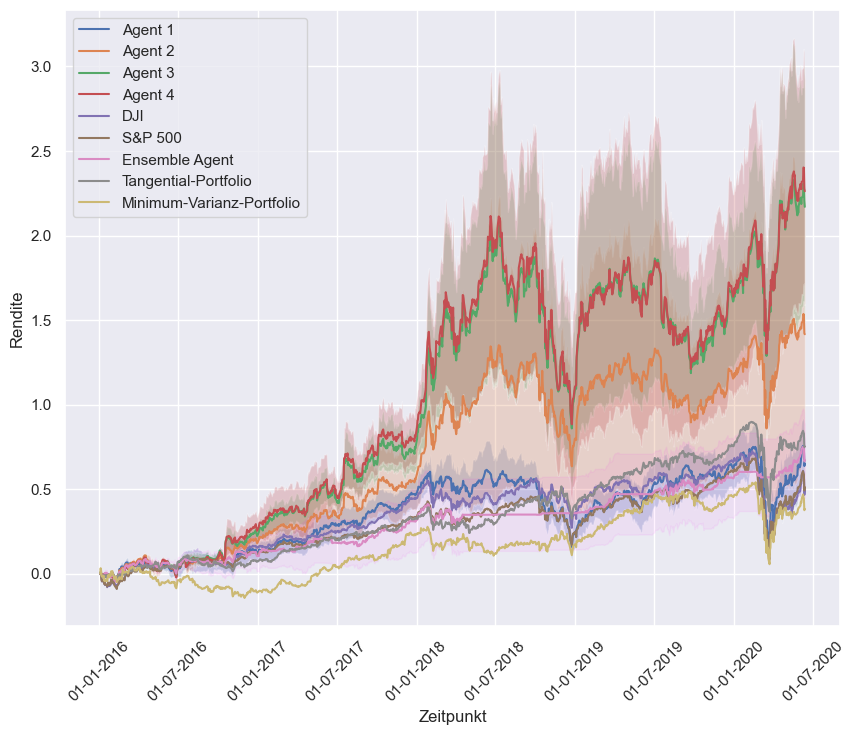

In [37]:
plt.figure(figsize=(10,8))
for agent_num in range(4):
    plt.plot(
        pd.to_datetime(testing_data.index),
        mean_cum_returns_best_agents[agent_num],
        label=f'Agent {agent_num+1}'
        )

    plt.fill_between(
        pd.to_datetime(testing_data.index), 
        mean_cum_returns_best_agents[agent_num] - std_cum_returns_best_agents[agent_num], 
        mean_cum_returns_best_agents[agent_num] + std_cum_returns_best_agents[agent_num], 
        alpha=0.25)
    

# Plot the cumulative return of the DJI
plt.plot(
        pd.to_datetime(closes_dji.index), 
        cum_returns_dji,
        label='DJI'
        )

# Plot the cumulative return of the S&P 500
plt.plot(
        pd.to_datetime(closes_sp500.index), 
        cum_returns_sp500,
        label='S&P 500'
        )

# Plot the cumulative return of the ensemble agent
plt.plot(
    pd.to_datetime(mean_cum_returns_ensemble.index),
    mean_cum_returns_ensemble,
    label='Ensemble Agent',
)

plt.fill_between(
        pd.to_datetime(mean_cum_returns_ensemble.index), 
        mean_cum_returns_ensemble - std_cum_returns_ensemble,
        mean_cum_returns_ensemble + std_cum_returns_ensemble, 
        alpha=0.05,
        color='fuchsia')


# Plot the cumulative return of tangency portfolio
plt.plot(
    pd.to_datetime(cum_returns_tp.index),
    cum_returns_tp,
    label='Tangential-Portfolio'
)

# Plot the cumulative return of the minimum variance portfolio
plt.plot(
    pd.to_datetime(cum_returns_mvp.index),
    cum_returns_mvp,
    label='Minimum-Varianz-Portfolio'
)


# Adjust the y and x label
plt.ylabel('Rendite')
plt.xlabel('Zeitpunkt');

plt.legend()
plt.xticks(rotation=45);
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

# Adjust the y and x label
plt.ylabel('Rendite')
plt.xlabel('Zeitpunkt');

In [38]:
# Mean cum. return of ensemble agent (over 1.1.2018-1.8.2018)
mean_cum_returns_ensemble.loc[(mean_cum_returns_ensemble.index <= '2018-08-01') & (mean_cum_returns_ensemble.index >= '2018-01-01')].mean()

0.34748123559581245

The curves between agent 1-4 look very similar! Further analysis that show this relationship:

In [39]:
# Get the mean asset history for agent
returns_agents = pd.DataFrame({
                    'Agent 1': agent_asset_values_mean[0],
                    'Agent 2': agent_asset_values_mean[1], 
                    'Agent 3': agent_asset_values_mean[2], 
                    'Agent 4': agent_asset_values_mean[3]
                    })

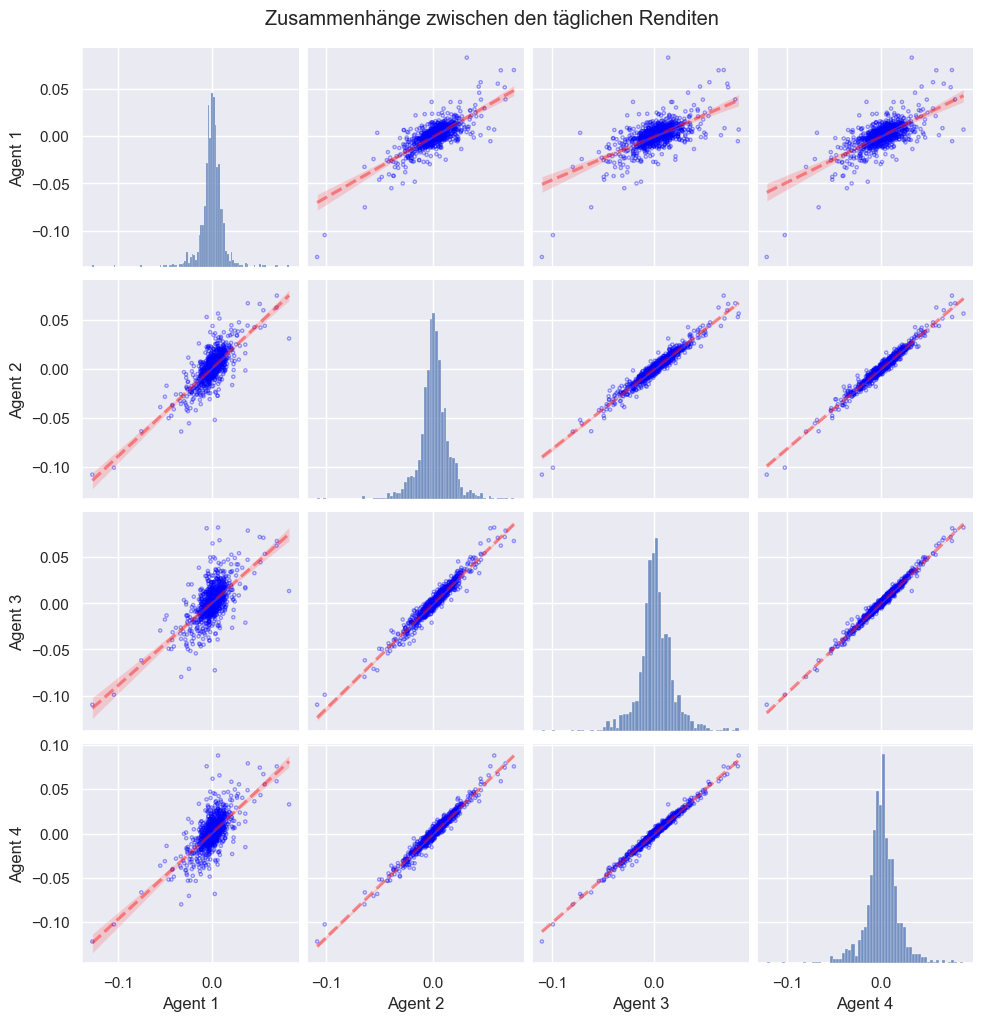

In [40]:
# Create a pairplot and plot a regression line 
p = sns.pairplot(
            data=returns_agents.pct_change(),
            kind='reg',
            diag_kind='hist',
            plot_kws={
                'scatter_kws': {'s': 5,'alpha':0.4, 'facecolors': 'none', 'edgecolor': 'blue'},
                'line_kws': {'color': 'red','alpha':0.4,'ls':'--'}
                }
            )
p.fig.suptitle('Zusammenhänge zwischen den täglichen Renditen', y=1.02);

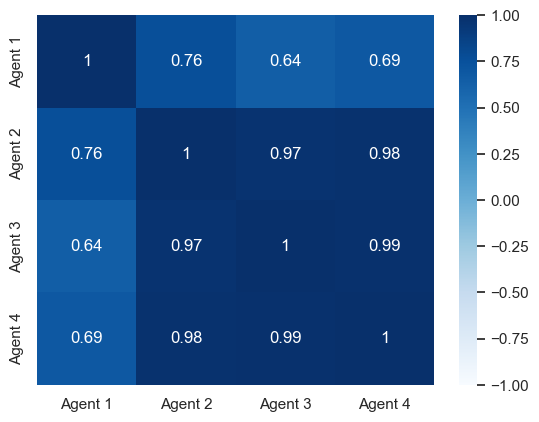

In [41]:
sns.heatmap(
        returns_agents.pct_change().corr(method='pearson'),
        cmap='Blues',
        vmin=-1,vmax=1,
        annot=True);

### Statistics for each trading curve

In [42]:
# Save for each agent and benchmark the asset history in a dictionary
asset_histories = {
                    'A1': agent_asset_values_mean[0],
                    'A2': agent_asset_values_mean[1],
                    'A3': agent_asset_values_mean[2],
                    'A4': agent_asset_values_mean[3],
                    'DJI': closes_dji.values,
                    'S&P500': closes_sp500.values,
                    'EA': mean_asset_history_ensemble_agent, 
                    'TP':price_devlopment_tp_total,
                    'MVP':price_devlopment_mvp_total
                    }

In [43]:
statistics_strategies = defaultdict()

for trading_strat in asset_histories.keys():
    # Calculate the daily return and convert to pd Series 
    asset_history= asset_histories[trading_strat]
    pct_changes = np.diff(asset_history)/asset_history[:-1]
    df = pd.Series(pct_changes)
    df.index = pd.to_datetime(testing_data.index[1:])

    # Calculate different measures (annual return, last cumulative return,
    # annual volatility, max drawdown, ...) and save the measures
    statistics_strategies[trading_strat] = {
                    'Jährliche Rendite': empyrical.annual_return(df),
                    'Gesamtrendite': empyrical.cum_returns_final(df),
                    'Jährliche Volatilität': empyrical.annual_volatility(df),
                    'Maximaler Wertverlust': -empyrical.max_drawdown(df),
                    'Sharpe-Ratio': empyrical.sharpe_ratio(df),
                    'Sortino-Ratio': empyrical.sortino_ratio(df), 
                    'Calmar-Ratio': empyrical.calmar_ratio(df),
                    'Value at Risk (95%)': empyrical.value_at_risk(df,cutoff=0.05),
                    'Value at Risk (99%)': empyrical.value_at_risk(df,cutoff=0.01),
                    'Expected Shortfall (95%)': empyrical.conditional_value_at_risk(df,cutoff=0.05),
                    'Expected Shortfall (99%)': empyrical.conditional_value_at_risk(df,cutoff=0.01)
                    }

In [44]:
statistics_strategies_df = pd.DataFrame(statistics_strategies).round(4)

In [45]:
# Display the dataframe as a heatmap
heatmap_df = (
    statistics_strategies_df # Data
    .style
    .background_gradient(cmap=sns.cubehelix_palette(start=2, rot=0.1, as_cmap=True), axis=1) # Colors
    .format("{:.4f}") # Round values to 4 decimal places
)

heatmap_df


## Portfolio Allocation

In [46]:
# Get the unique tickers
tickers = testing_data.columns.get_level_values(1).unique()

# Number of runs for each seed
num_runs_per_seed = 5

# Create empty arrays to store the shares, prices and cash for each seed 
shares_over_seeds = np.zeros(shape=(NUM_AGENTS,len(SEEDS),num_runs_per_seed,len(testing_data)-1, len(tickers))) # Agent, SEED, Number of Runs per Seed, Length of testing data (-1 because first day is just cash), number of stocks
prices_over_seeds = np.zeros(shape=(NUM_AGENTS,len(SEEDS),num_runs_per_seed,len(testing_data)-1, len(tickers)))
cash_over_seeds = np.zeros(shape=(NUM_AGENTS,len(SEEDS),num_runs_per_seed,len(testing_data)-1))


Run the policy for each agent-seed combination n-times (here 5) and get the mean number of shares and mean amount of cash over time 

In [47]:
# Loop over the different seeds
for seed_idx,seed in enumerate(SEEDS):
    # Loop over the different agents 
    for agent_num, (consider_sentiment, consider_sharpe) in enumerate(zip(CONSIDER_SENTIMENTS, CONSIDER_SHARPES)):
        
        # Define the env in which the policy should be run
        test_env = gym.make(
                            'Trading-v4', 
                            market_data=testing_data, 
                            turbulence_index=turbulence_testing,
                            consider_sentiments=consider_sentiment, 
                            n_step_sharpe=consider_sharpe,
                        )

        # Define the agent
        if agent_num == 3:
            agent = RecurrentPPO.load(
                        f'/Applications/Studium/Master/Masterarbeit/AADRL/train_agents/training_eval/agent_{agent_num+1}_seed_{seed}/best_model.zip'
                        )
        else:
            agent = PPO.load(
                        f'/Applications/Studium/Master/Masterarbeit/AADRL/train_agents/training_eval/agent_{agent_num+1}_seed_{seed}/best_model.zip'
                        )
        
        # Run the policy get the shares, prices and cash per run
        shares, prices, cash = run_policy(test_env,agent,n_eval_episodes=num_runs_per_seed)

        # Save the shares, prices and cash for the corresponding seed
        shares_over_seeds[agent_num,seed_idx,:,:,:] = shares
        prices_over_seeds[agent_num,seed_idx,:,:,:] = prices
        cash_over_seeds[agent_num,seed_idx,:,:] = cash

In [48]:
# Calculate mean shares over time
mean_shares_over_time = shares_over_seeds.mean(axis=2).mean(axis=1)

# Calculate the mean cash position over time
cash_position_over_time = cash_over_seeds.mean(axis=2).mean(axis=1)

### Mean Absolute and Relative Number of Shares per Stock over Time

In [49]:
# Save the mean shares over time in a dataframe
mean_shares_over_time = [pd.DataFrame(df, columns=tickers,index=pd.to_datetime(testing_data.index[1:])) for df in mean_shares_over_time]

# Calculate the percentage value of holding shares per timestep
percentages_shares_over_time = [df.div(df.sum(axis=1), axis=0) * 100 for df in mean_shares_over_time]

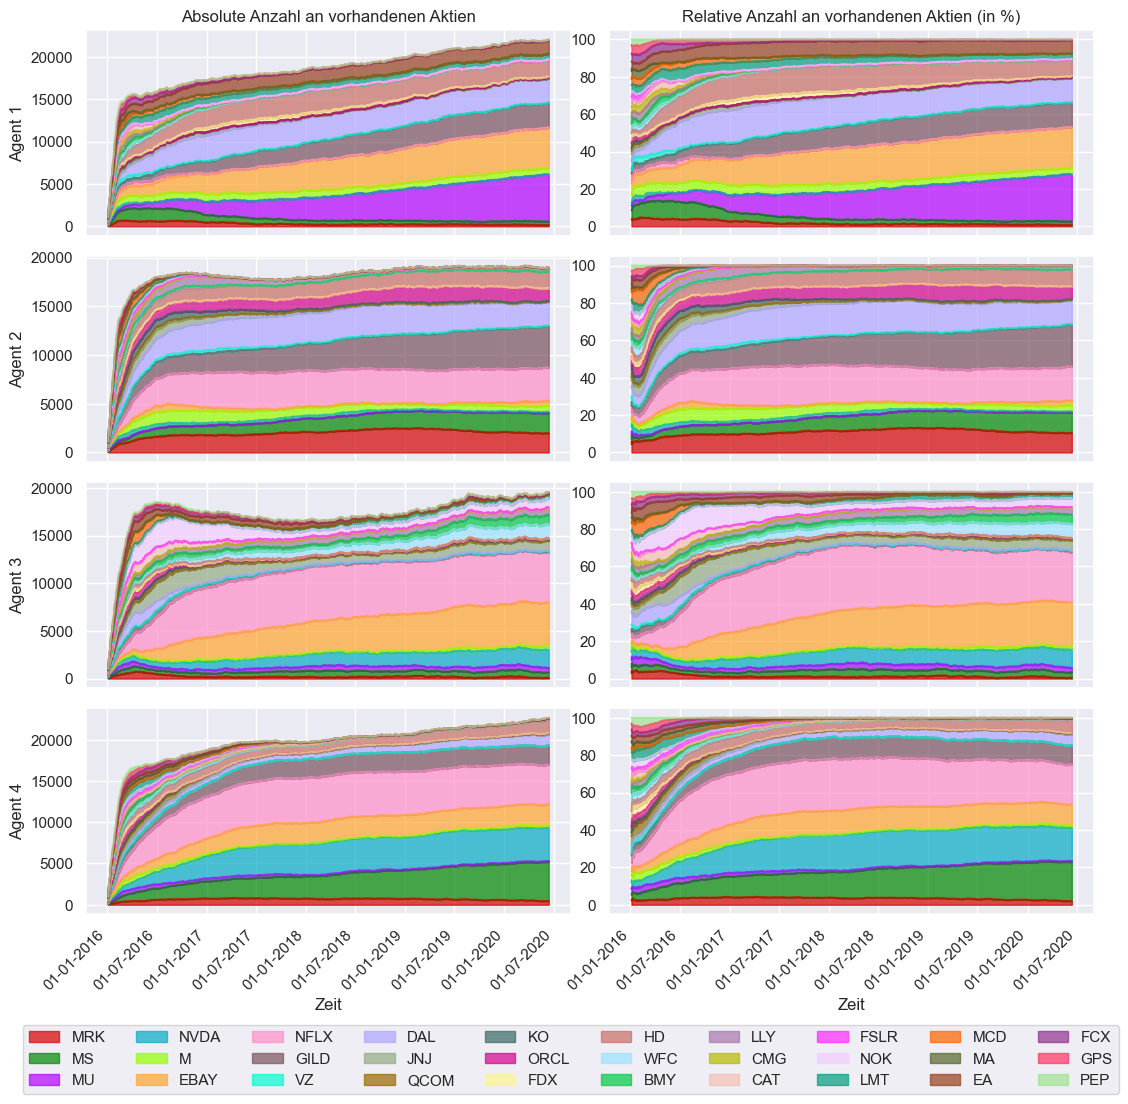

In [50]:
sns.set_theme()
# Create a subplot
fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (13,13),sharex=True)

# Loop over the agents
for agent_num in range(4):
    # Loop over dataframes containing mean absolute 
    for i,df in enumerate([mean_shares_over_time[agent_num], percentages_shares_over_time[agent_num]]):

        #  Plot an area plot to display the portfolio allocation over time (without weighting the prices)
        plot = df.plot(
                    kind='area',
                    stacked=True,
                    color=sns.color_palette(cc.glasbey_light, n_colors=30),
                    alpha=0.7,
                    ax=ax[agent_num][i]
                    )

        # Display only once the legend
        if i == 0 and agent_num == 0:
            ax[agent_num][i].legend(loc='upper center', bbox_to_anchor=(1, -3.8), ncol=len(df.columns)//3)
        else:
            ax[agent_num][i].get_legend().remove()

        # Rotate the xticks and format the date
        ax[agent_num][i].tick_params(axis='x', rotation=45)
        ax[agent_num][i].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        ax[agent_num][i].set_xlabel('Zeit')
    
    ax[agent_num][0].set_ylabel(f'Agent {agent_num+1}')

ax[0][0].set_title('Absolute Anzahl an vorhandenen Aktien')
ax[0][1].set_title('Relative Anzahl an vorhandenen Aktien (in %)');
plt.subplots_adjust(wspace=0.08, hspace=0.1)

### Mean Absolute and Relative Number of Shares per Sector over Time

In [51]:
# Define the mapping from ticker to sector (see preprocessing)
ticker_to_sector = {
    'MRK': 'Gesundheitswesen',
    'MS': 'Finanzdienstleister',
    'MU': 'Technologie',
    'NVDA': 'Technologie',
    'M': 'Zyklischer Konsum',
    'EBAY': 'Zyklischer Konsum',
    'NFLX': 'Kommunikationsdienste',
    'GILD': 'Gesundheitswesen',
    'VZ': 'Kommunikationsdienste',
    'DAL': 'Industrie',
    'JNJ': 'Gesundheitswesen',
    'QCOM': 'Technologie',
    'KO': 'Stabiler Konsum',
    'ORCL': 'Technologie',
    'FDX': 'Industrie',
    'HD': 'Zyklischer Konsum',
    'WFC': 'Finanzdienstleister',
    'BMY': 'Gesundheitswesen',
    'LLY': 'Gesundheitswesen',
    'CMG': 'Zyklischer Konsum',
    'CAT': 'Industrie',
    'FSLR': 'Technologie',
    'NOK': 'Technologie',
    'LMT': 'Industrie',
    'MCD': 'Zyklischer Konsum',
    'MA': 'Finanzdienstleister',
    'EA': 'Kommunikationsdienste',
    'FCX': 'Grundmaterialien',
    'GPS': 'Zyklischer Konsum',
    'PEP': 'Stabiler Konsum'
}

In [52]:
tmp1 = []
tmp2 = []

for df in mean_shares_over_time:
    # Melt the previous dataframe 
    mean_shares_over_time_melted = df.reset_index().melt(
                                                        id_vars=['index'], 
                                                        var_name='Ticker', 
                                                        value_name='Value'
                                                        )

    # Map tickers to the corresponding sectors
    mean_shares_over_time_melted['Sector'] = mean_shares_over_time_melted['Ticker'].map(ticker_to_sector)

    # Group by time and sector and take the sum
    sector_sums = mean_shares_over_time_melted.groupby(['index','Sector'])['Value'].sum().reset_index()

    # Create pivot table that contains the total numbers of 
    portfolio_allocation_sectors = sector_sums.pivot_table(
                                                        index='index',
                                                        columns='Sector',
                                                        values='Value'
                                                        )


    # Sort the columns (to match the colors as in preprocessing)
    portfolio_allocation_sectors = portfolio_allocation_sectors[[
                                                                'Gesundheitswesen',
                                                                'Finanzdienstleister',
                                                                'Technologie',
                                                                'Zyklischer Konsum',
                                                                'Kommunikationsdienste',
                                                                'Industrie',
                                                                'Stabiler Konsum',
                                                                'Grundmaterialien'
                                                                ]]

    # Calculate the percentages per sector
    percentages_sector = portfolio_allocation_sectors.div(portfolio_allocation_sectors.sum(axis=1), axis=0) * 100

    # Save the tables
    tmp1.append(portfolio_allocation_sectors)
    tmp2.append(percentages_sector)

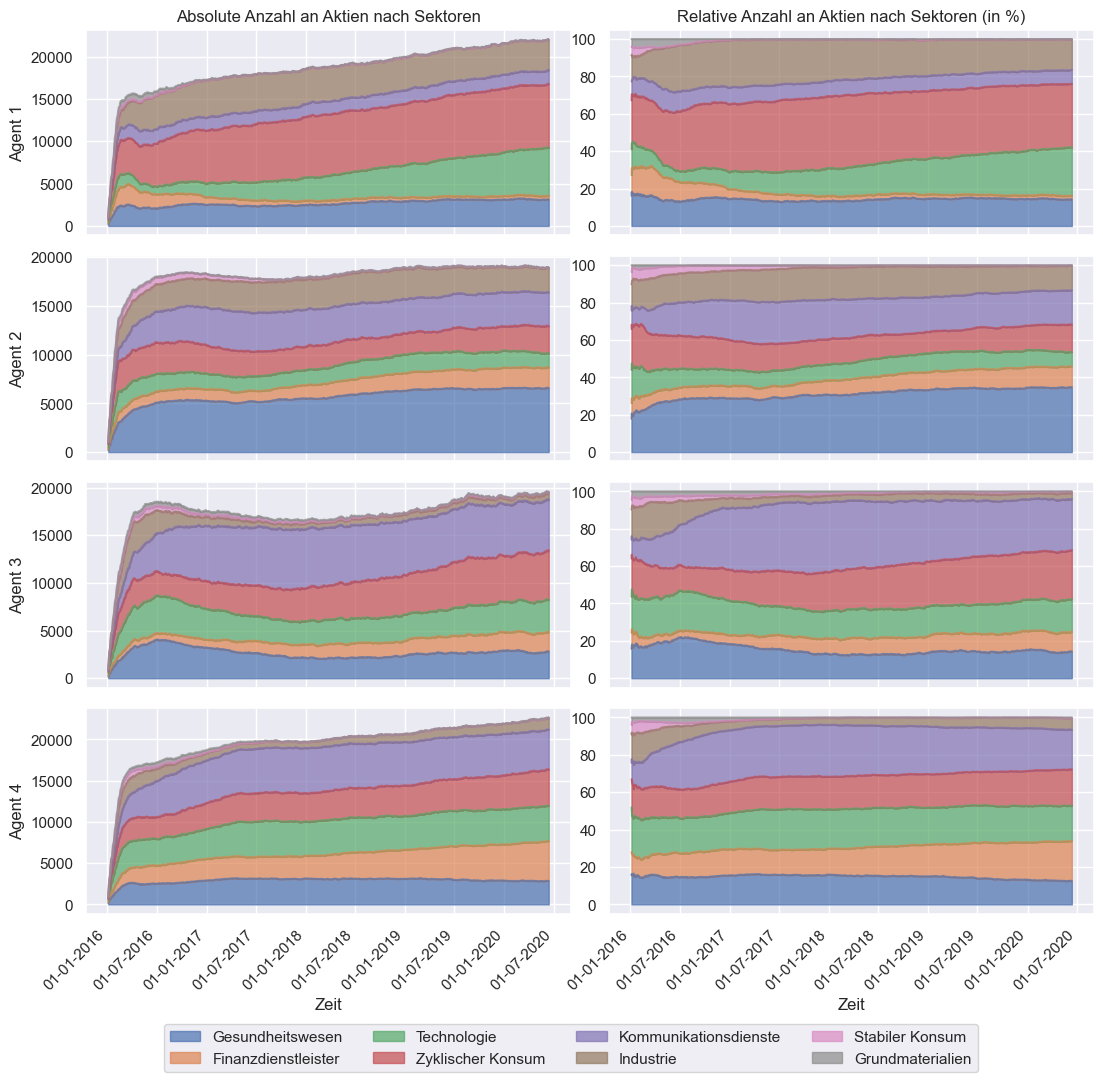

In [53]:
sns.set_theme()
# Create a subplot
fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (13,13),sharex=True)

idx = 0
dfs = [tmp1, tmp2]

for row,agent_num in enumerate(range(4)):
    for col,df in enumerate([tmp1[agent_num], tmp2[agent_num]]):
                
        # Rename the index column 
        df = df.rename_axis("Zeit")

        # Plot an area plot to display the portfolio allocation over time
        df.plot(
                kind='area',
                stacked=True,
                alpha=0.7,
                ax=ax[row][col]
                )
        
        # Display only once the legend  
        if row == 0 and col == 0:
            ax[row][col].legend(loc='upper center', bbox_to_anchor=(1, -3.8), ncol=len(df.columns)//2)
        else:
            ax[row][col].get_legend().remove()

        # Rotate the xticks and format the date
        ax[row][col].tick_params(axis='x', rotation=45)
        ax[row][col].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        ax[row][col].set_xlabel('Zeit')
        if col == 0:
            ax[row][col].set_ylabel(f'Agent {agent_num+1}')

ax[0][0].set_title('Absolute Anzahl an Aktien nach Sektoren')
ax[0][1].set_title('Relative Anzahl an Aktien nach Sektoren (in %)');
plt.subplots_adjust(wspace=0.08, hspace=0.1)

### (Actual) Portfolioallocation - Weighting the mean shares over time with the prices

In [54]:
# Copy the previous dataframe 
mean_shares_over_time_with_cash = mean_shares_over_time.copy()
weighted_num_assets = mean_shares_over_time.copy()
weighted_percentages = mean_shares_over_time.copy()

for i,df in enumerate(mean_shares_over_time_with_cash):
    # Add cash position to the dataframe
    mean_shares_over_time_with_cash[i]['Bargeld'] = cash_position_over_time[i]

    # Weight the previous dataframe (containing the shares) with the prices and calculate the percentages
    weighted_num_assets[i] = mean_shares_over_time_with_cash[i] *  np.concatenate((np.array(prices),np.ones((np.array(prices).shape[0], 1))),axis=1) 
    weighted_percentages[i] = weighted_num_assets[i].div(weighted_num_assets[i].sum(axis=1), axis=0) * 100

In [55]:
# Map each stock to the corresponding industry and aggregate the values
weighted_percentages_sectors = []

for i,df in enumerate(weighted_num_assets):
    # Melt for easier data format
    data_melted_weighted = df.reset_index().melt(id_vars=['index'], var_name='Ticker', value_name='Value')

    # Map tickers to the corresponding sectors
    data_melted_weighted['Sector'] = data_melted_weighted['Ticker'].map(ticker_to_sector)

    # Group by time and sector and take the sum
    sector_sums_weighted = data_melted_weighted.groupby(['index','Sector'])['Value'].sum().reset_index()
    sector_sums_weighted = sector_sums_weighted.pivot_table(index='index',columns='Sector',values='Value')
    
    # Reorder to match the colors of preprocessing
    sector_sums_weighted = sector_sums_weighted[[
                                                'Gesundheitswesen',
                                                'Finanzdienstleister',
                                                'Technologie',
                                                'Zyklischer Konsum',
                                                'Kommunikationsdienste',
                                                'Industrie',
                                                'Stabiler Konsum',
                                                'Grundmaterialien'
                                                ]]

    # Add cash position to portfolio 
    sector_sums_weighted['Bargeld'] = cash_position_over_time[i]

    weighted_percentages_sectors.append(sector_sums_weighted.div(sector_sums_weighted.sum(axis=1), axis=0) * 100)

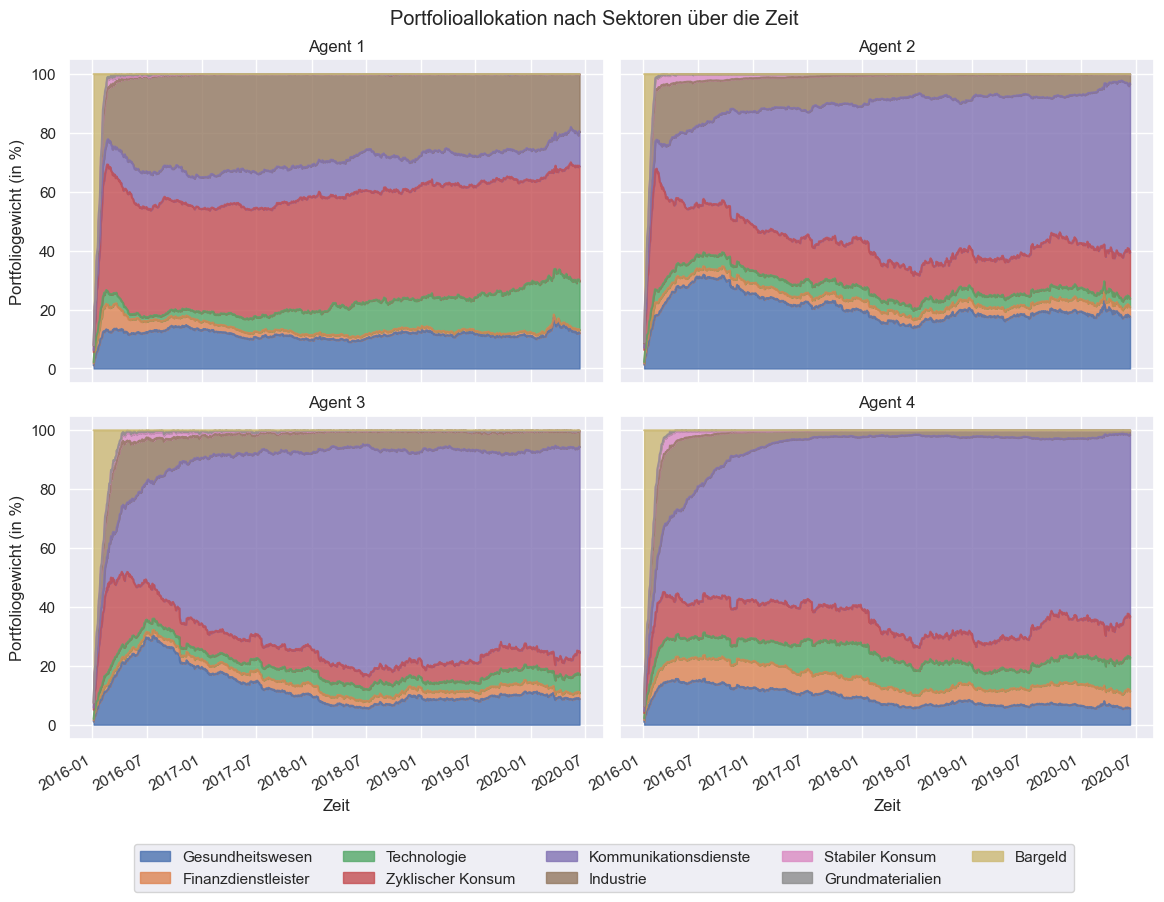

In [56]:
# Create subplot
fig, ax = plt.subplots(nrows=2, ncols = 2,figsize=(14,10),sharex=True,sharey=True)

# Set col and row indeces for plotting
col=0
row=0

# Loop over the different agents
for i in range(4):
    # Plot the area plot for portfolio allocation
    plot = weighted_percentages_sectors[i].plot(
                                            kind='area', 
                                            stacked=True, 
                                            alpha=0.8, 
                                            ax = ax[row][col])

    # Display only once the legend
    if i == 0:
        ax[row][col].legend(loc='upper center', bbox_to_anchor=(1, -1.4), ncol=5)
    else:
        ax[row][col].get_legend().remove()

    # Adjust the title
    ax[row][col].set_title(f'Agent {i + 1}')

    # Adjust row and col indeces
    col += 1
    if col == 2:
        row += 1
        col = 0

# Adjust labels
ax[1][0].set_xlabel('Zeit')
ax[1][1].set_xlabel('Zeit')
ax[0][0].set_ylabel('Portfoliogewicht (in %)')
ax[1][0].set_ylabel('Portfoliogewicht (in %)')

# Add suptitle
plt.suptitle('Portfolioallokation nach Sektoren über die Zeit', y = 0.93);
plt.subplots_adjust(wspace=0.03, hspace=0.1)

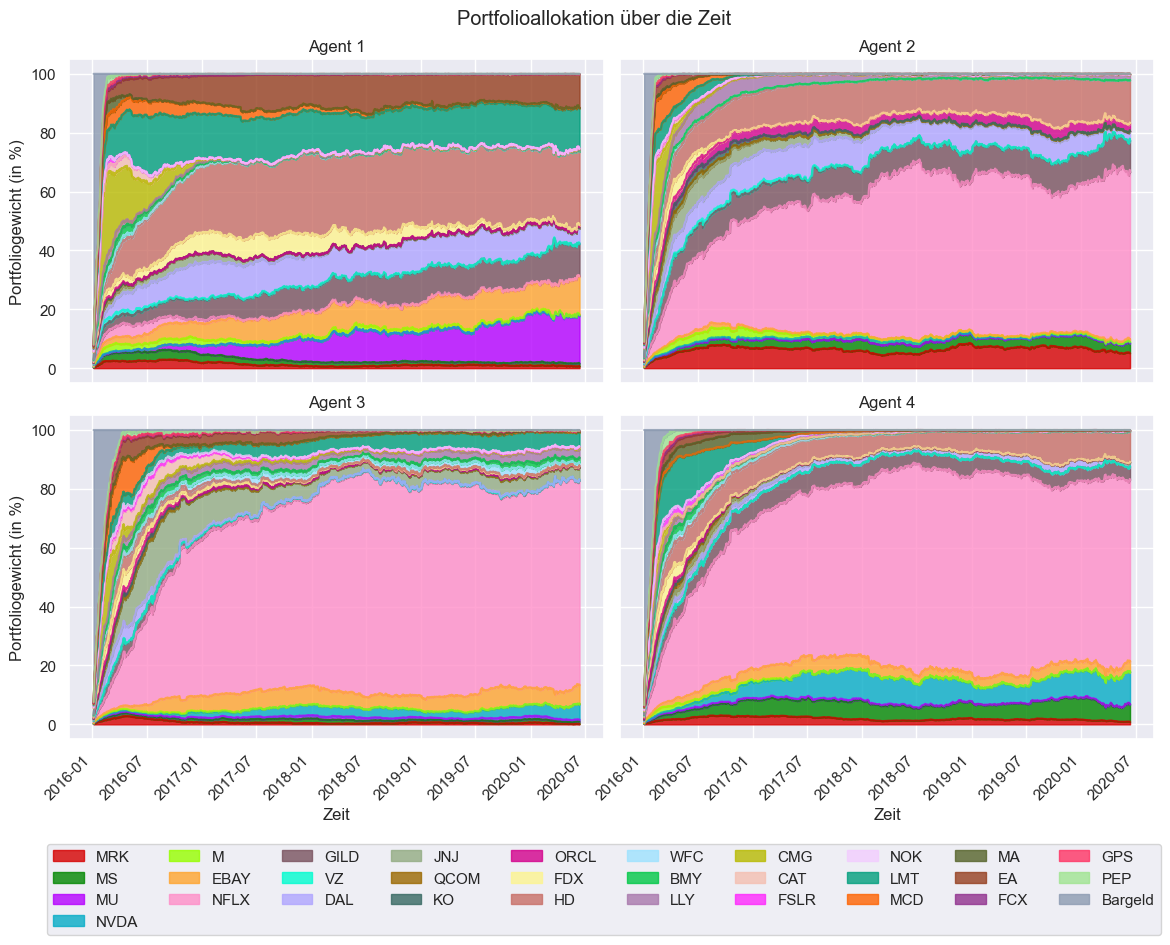

In [57]:
# Create subplot
fig, ax = plt.subplots(nrows=2, ncols = 2,figsize=(14,10),sharex=True,sharey=True)

# Set col and row indeces for plotting
col=0
row=0
for i in range(4):
    # Plot the area plot for portfolio allocation
    plot = weighted_percentages[i].plot(
                                        kind='area', 
                                        stacked=True, 
                                        alpha=0.8, 
                                        ax = ax[row][col],
                                        color=sns.color_palette(cc.glasbey_light, n_colors=31))
                                        #alpha=0.8)

    # Display only once the legend
    if i == 0:
        ax[row][col].legend(loc='upper center', bbox_to_anchor=(1, -1.4), ncol=len(df.columns)//3)
    else:
        ax[row][col].get_legend().remove()

    # Adjust the title
    ax[row][col].set_title(f'Agent {i + 1}')
    ax[row][col].tick_params(axis='x', rotation=45)

    # Adjust col and row indeces
    col += 1
    if col == 2:
        row += 1
        col = 0

# Adjust labels
ax[1][0].set_xlabel('Zeit')
ax[1][1].set_xlabel('Zeit')
ax[0][0].set_ylabel('Portfoliogewicht (in %)')
ax[1][0].set_ylabel('Portfoliogewicht (in %)')

# Add suptitle
plt.suptitle('Portfolioallokation über die Zeit', y = 0.93);
plt.subplots_adjust(wspace=0.03, hspace=0.1)

In [58]:
# Weight of the netflix stock at the end of the trading period
for agent_num in range(4):
    print(f'Gewicht Netflix Aktie - Agent {agent_num+1}', weighted_percentages[agent_num]['NFLX'].iloc[-1])

Gewicht Netflix Aktie - Agent 1 0.1623095189936979
Gewicht Netflix Aktie - Agent 2 56.70332806849385
Gewicht Netflix Aktie - Agent 3 69.20489439882508
Gewicht Netflix Aktie - Agent 4 61.46888416947538


In [59]:
# Weight of HD stock for the fourth agent (end of period)
weighted_percentages[3]['HD'][-1]

10.245921657081002

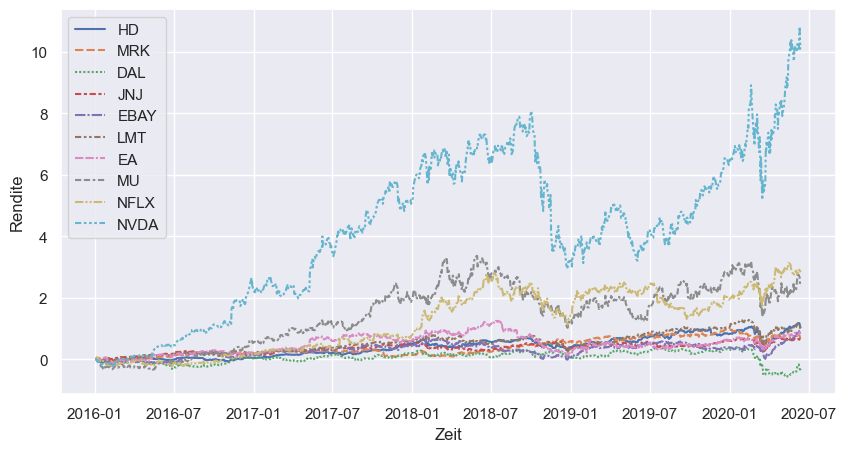

In [60]:
# Plot the returns for the stocks that the agents invest most in

# Get the close prices
adj_close_specific_stocks = testing_data['Adj Close'][['HD','MRK','DAL','JNJ','EBAY','LMT','EA','MU','NFLX','NVDA']]

# Calculate the cumulative return and add the time index
cumulative_returns_specific_stocks= adj_close_specific_stocks/adj_close_specific_stocks.iloc[0]-1
cumulative_returns_specific_stocks.index = pd.to_datetime(cumulative_returns_specific_stocks.index)

# Create the plot
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=cumulative_returns_specific_stocks, ax=ax, linestyle='--')
ax.set_xlabel('Zeit')
ax.set_ylabel('Rendite')
plt.show()

### Comparison of NFLX stock price and Agent 4's performance

In [61]:
# Get close prices of netflix
closes_nflx = testing_data['Adj Close']['NFLX'] 

# Calculate the cumulative returns
initial_val_nflx = closes_nflx[0]
cum_returns_nflx = closes_nflx/initial_val_nflx - 1

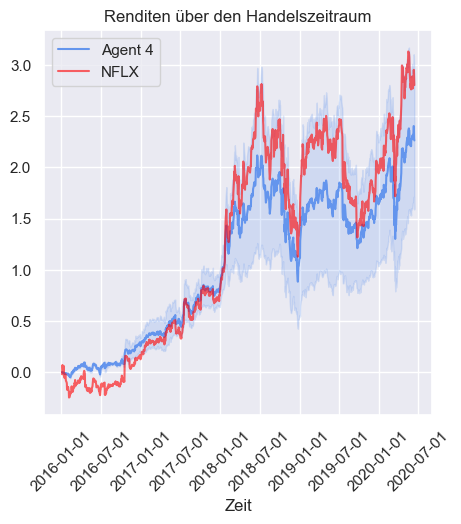

In [62]:
fig, ax = plt.subplots(figsize=(5, 5))

# Return over time of agent 4
plt.plot(
    pd.to_datetime(testing_data.index),
    mean_cum_returns_best_agents[3],
    label=f'Agent 4',color='cornflowerblue'
    )

plt.fill_between(
    pd.to_datetime(testing_data.index), 
    mean_cum_returns_best_agents[3] - std_cum_returns_best_agents[3], 
    mean_cum_returns_best_agents[3] + std_cum_returns_best_agents[3], 
    alpha=0.2,color='cornflowerblue')

# Return over time of Netflix
plt.plot(
    pd.to_datetime(testing_data.index),
    cum_returns_nflx,
    label='NFLX',color='red',alpha=0.6)

plt.legend()
plt.title('Renditen über den Handelszeitraum')
plt.xticks(rotation=45);
plt.xlabel('Zeit')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

The performance of the agent is mainly driven by NFLX! This was as expected, since the agent put a lot of weight on NFLX (see portfolio allocation above). To see whether the Agent's trading strategy differs from NFLX, one can analyse the daily returns, analyse the distribution and perform a Kolmogorov-Smirnov Test. This will be done now. 

In [63]:
# Get the portfolio value f the fourth agent
asset_history_agent_4 = agent_asset_values_mean[3]

In [64]:
# Get the daily returns for the agent 4, nflx, dji and s&p 500
daily_returns_agent4 = np.ravel(pd.DataFrame(asset_history_agent_4).pct_change().dropna())
daily_returns_nflx = np.ravel(pd.DataFrame(closes_nflx).pct_change().dropna())

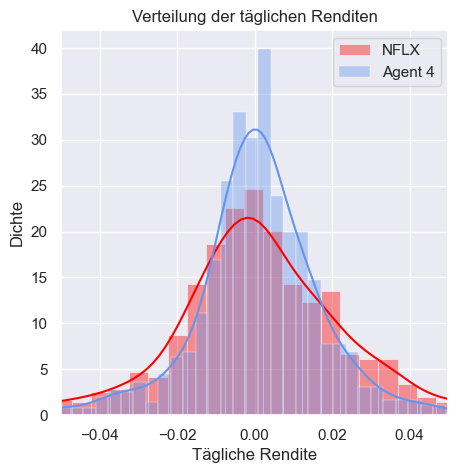

In [65]:
# Create a distribution plot over the daily returns
fig, ax = plt.subplots(figsize=(5, 5))

# Plot daily returns NFLX
sns.histplot(
            daily_returns_nflx,
            kde=True, 
            stat='density',
            label='NFLX',
            color='red',
            ax=ax,
            alpha=0.4
            )

# Plot daily returns Agent 4
sns.histplot(
            daily_returns_agent4,
            kde=True, 
            stat='density',
            label='Agent 4',
            color='cornflowerblue',
            alpha=0.4
            )

plt.xlabel('Tägliche Rendite')
plt.xlim(-0.05,0.05)
plt.legend()
plt.ylabel('Dichte')
plt.title('Verteilung der täglichen Renditen');

In [66]:
# Kolmogorov Smirnov Test to check whether the distribution of daily returns between nflx and agent4 are significantly different
kstest(
    daily_returns_agent4, 
    daily_returns_nflx
    )

# P-Value about 0.1% -> significant difference between nflx and agent4. Thus, altough a large investment is into nflx, the agent
# did not only learn to trade nflx

KstestResult(statistic=0.09749552772808587, pvalue=4.791934278362145e-05, statistic_location=0.016858577674275788, statistic_sign=1)

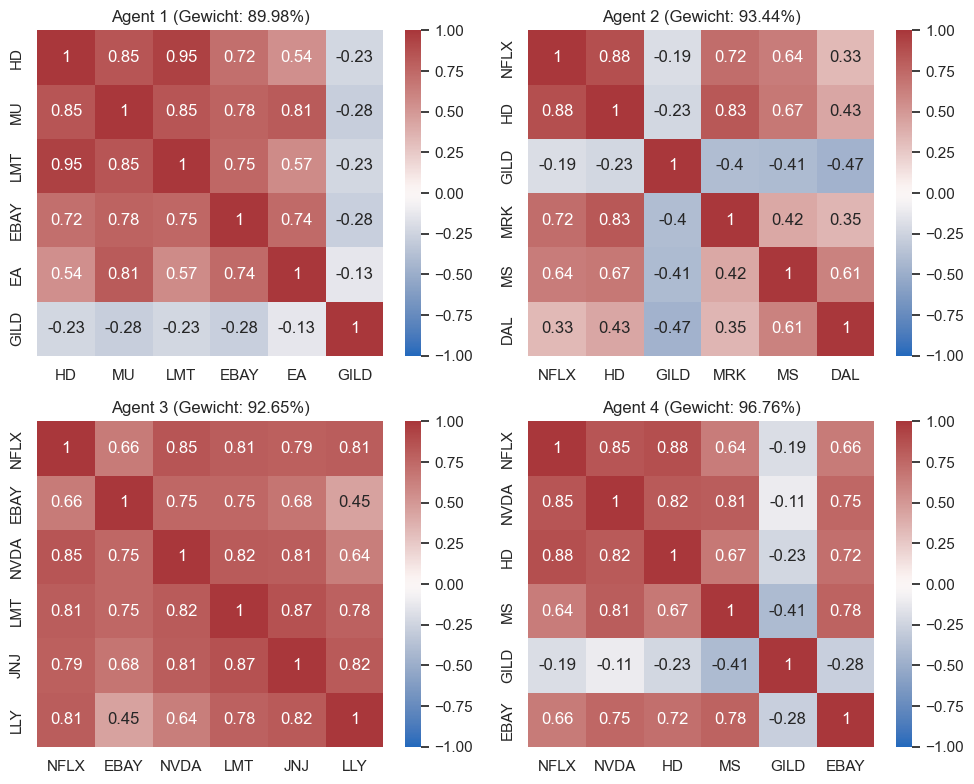

In [67]:
# Plot the correlation matrix of the stocks that the agent has at the and the highest weights
# over the test dataset 

sns.set_context('notebook', font_scale=1)  # Adjust the size of the text

# Create subplot
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,8))

# Create row and col indeces
row = 0
col = 0

# How many stocks should be taken into consideration (with the highest values)
n_largest = 6

# Loop over the agents
for agent_num in range(4):
    # Get the stocks with the highest weights
    highest_weights = list(weighted_percentages[agent_num].iloc[-1].nlargest(n_largest).index)

    # Calculate sum over the weights
    weights_sum = weighted_percentages[agent_num].iloc[-1].nlargest(n_largest).sum()

    # Plot correlation matrix over the adjusted close prices
    g = sns.heatmap(
        testing_data['Adj Close'][highest_weights].corr(),
        ax = ax[row][col],
        cmap=sns.color_palette("vlag", as_cmap=True),
        vmin=-1,
        vmax=1,
        annot=True
        )
    
    # Adjust col and row indeces
    col += 1
    if col == 2:
        row += 1
        col = 0

    # Add title
    g.set_title(f'Agent {agent_num + 1} (Gewicht: {weights_sum:.2f}%)')
    
fig.tight_layout()

In [68]:
# Print the weights of the stocks in which the agent is highest invested at the end
for num_agent in range(4):
    print(f'Agent {num_agent+1}',round(weighted_percentages[num_agent].iloc[-1].nlargest(n_largest),2))
    print('')

Agent 1 HD      25.08
MU      16.05
LMT     13.54
EBAY    13.01
EA      11.38
GILD    10.92
Name: 2020-06-12 00:00:00, dtype: float64

Agent 2 NFLX    56.70
HD      14.72
GILD    10.63
MRK      5.11
MS       3.34
DAL      2.93
Name: 2020-06-12 00:00:00, dtype: float64

Agent 3 NFLX    69.20
EBAY     6.46
NVDA     5.35
LMT      4.58
JNJ      4.19
LLY      2.87
Name: 2020-06-12 00:00:00, dtype: float64

Agent 4 NFLX    61.47
NVDA    11.01
HD      10.25
MS       5.96
GILD     4.53
EBAY     3.54
Name: 2020-06-12 00:00:00, dtype: float64



In [69]:
# Get for each stock the performance metrics over the training dataset
statistics_stocks_training = defaultdict()

# Loop over the stocks
for stock in training_data['Adj Close'].keys():
    
    # Calculate the daily return and convert to pd Series 
    asset_history= training_data['Adj Close'][stock]
    pct_changes = np.diff(asset_history)/asset_history[:-1]
    df = pd.Series(pct_changes)
    df.index = pd.to_datetime(training_data.index[1:])

    # Calculate different measures (annual return, last cumulative return,
    # annual volatility, max drawdown, ...) and save the measures
    statistics_stocks_training[stock] = {
                    'Jährliche Rendite': empyrical.annual_return(df),
                    'Gesamtrendite': empyrical.cum_returns_final(df),
                    'Jährliche Volatilität': empyrical.annual_volatility(df),
                    'Maximaler Wertverlust': -empyrical.max_drawdown(df),
                    'Sharpe-Ratio': empyrical.sharpe_ratio(df),
                    'Sortino-Ratio': empyrical.sortino_ratio(df), 
                    'Calmar-Ratio': empyrical.calmar_ratio(df),
                    'Value at Risk (95%)': empyrical.value_at_risk(df,cutoff=0.05),
                    'Value at Risk (99%)': empyrical.value_at_risk(df,cutoff=0.01),
                    'Expected Shortfall (95%)': empyrical.conditional_value_at_risk(df,cutoff=0.05),
                    'Expected Shortfall (99%)': empyrical.conditional_value_at_risk(df,cutoff=0.01)
                    }

In [70]:
statistics_strategies_df_stocks = pd.DataFrame(statistics_stocks_training).round(4).T

# Display the dataframe as a heatmap
heatmap_df = (
    statistics_strategies_df_stocks # Data
    .style
    .background_gradient(cmap=sns.cubehelix_palette(start=2, rot=0.1, as_cmap=True), axis=0) # Colors
    .format("{:.2f}") # Round values to 4 decimal places
)

heatmap_df


In [71]:
# Statistics on testing data 
statistics_stocks_training = defaultdict()

for stock in testing_data['Adj Close'].keys():
    # Calculate the daily return and convert to pd Series 
    asset_history= testing_data['Adj Close'][stock]
    pct_changes = np.diff(asset_history)/asset_history[:-1]
    df = pd.Series(pct_changes)
    df.index = pd.to_datetime(testing_data.index[1:])

    # Calculate different measures (annual return, last cumulative return,
    # annual volatility, max drawdown, ...) and save the measures
    statistics_stocks_training[stock] = {
                    'Jährliche Rendite': empyrical.annual_return(df),
                    'Gesamtrendite': empyrical.cum_returns_final(df),
                    'Jährliche Volatilität': empyrical.annual_volatility(df),
                    'Maximaler Wertverlust': -empyrical.max_drawdown(df),
                    'Sharpe-Ratio': empyrical.sharpe_ratio(df),
                    'Sortino-Ratio': empyrical.sortino_ratio(df), 
                    'Calmar-Ratio': empyrical.calmar_ratio(df),
                    'Value at Risk (95%)': empyrical.value_at_risk(df,cutoff=0.05),
                    'Value at Risk (99%)': empyrical.value_at_risk(df,cutoff=0.01),
                    'Expected Shortfall (95%)': empyrical.conditional_value_at_risk(df,cutoff=0.05),
                    'Expected Shortfall (99%)': empyrical.conditional_value_at_risk(df,cutoff=0.01)
                    }
    
statistics_strategies_df_stocks = pd.DataFrame(statistics_stocks_training).round(4).T

# Display the dataframe as a heatmap
heatmap_df = (
    statistics_strategies_df_stocks # Data
    .style
    .background_gradient(cmap=sns.cubehelix_palette(start=2, rot=0.1, as_cmap=True), axis=0) # Colors
    .format("{:.2f}") # Round values to 4 decimal places
)

heatmap_df


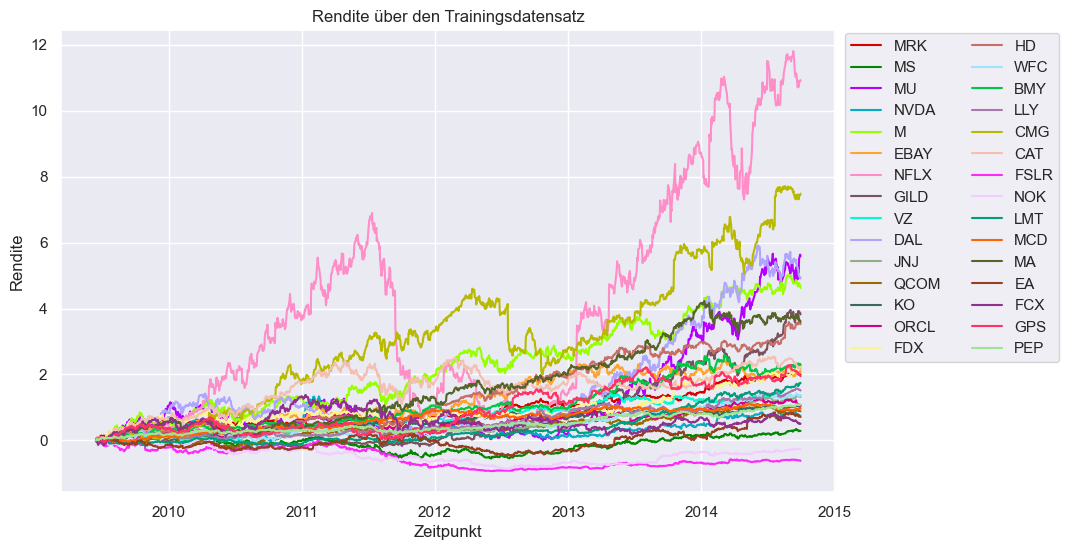

In [72]:
# Plot the return over time over the training dataset

# Create subplot
fig, ax = plt.subplots(figsize=(10,6))
training_data.index = pd.to_datetime(training_data.index)

# Display returns over time for the trainings dataset
g = sns.lineplot(
            data=training_data['Adj Close']/training_data['Adj Close'].iloc[0] - 1,                                        
            palette=sns.color_palette(cc.glasbey_light, n_colors=30),
            ax = ax
            )

# Set the line style to solid
for line in ax.get_lines():
    line.set_linestyle('-')

# Adjust legend
ax.legend(loc='upper center', bbox_to_anchor=(1.15, 1.01), ncol=2)

# Add title and labels
g.set_title('Rendite über den Trainingsdatensatz')
g.set_xlabel('Zeitpunkt')
g.set_ylabel('Rendite');

## Comparison of the Four Agents Through Time

Compare the agents during training instead of comparing the best models.

In [74]:
# Empty arrays to store the return, sharpe ratio and volaility
cumulative_returns_envs = np.zeros((3,NUM_AGENTS,len(SEEDS),NUMBER_SAVED_MODELS)) # Dataset, Agent, Seed, Agents that were saved during training 
sharpe_ratios_envs = np.zeros((3,NUM_AGENTS,len(SEEDS),NUMBER_SAVED_MODELS))
volatilities_envs = np.zeros((3,NUM_AGENTS,len(SEEDS),NUMBER_SAVED_MODELS))

In [75]:
# Extract the number of the model: model name needs to be of the shape model_step_xxxxx.zip
extract_number = lambda text: int(text.split('_')[-1].split('.')[0])

In [76]:
# Loop over the different datasets
for idx_dataset, (test_data, turbulence_data) in enumerate(
                                                        [(training_data,turbulence_training),
                                                        (validation_data,turbulence_validation),
                                                        (testing_data,turbulence_testing)]
                                                        ):
    # Loop over the different seeds
    for idx_seed, seed in enumerate(SEEDS):
        # Loop over the agents
        for agent_num, (consider_sentiment, consider_sharpe) in enumerate(zip(CONSIDER_SENTIMENTS, CONSIDER_SHARPES)):
            
            # Load all the models and sort them in ascending order
            directory = f'/Applications/Studium/Master/Masterarbeit/AADRL/train_agents/training_eval/agent_{agent_num+1}_seed_{seed}/models'
            zip_files = [f for f in os.listdir(directory)]
            zip_files_sorted = sorted(zip_files, key=extract_number)
            
            # Define the test env
            test_env = gym.make(
                            'Trading-v4', 
                            market_data=test_data, 
                            turbulence_index=turbulence_data,
                            consider_sentiments=consider_sentiment, 
                            n_step_sharpe=consider_sharpe,
                        )
            
            # Loop over the models 
            for idx_agent,agent_path in enumerate(zip_files_sorted):
                # Define the agent 
                if agent_num != 3:
                    agent = PPO.load(directory+'/'+agent_path)
                else:
                    agent = RecurrentPPO.load(directory+'/'+agent_path)
                
                # Evaluate policy on the given environment 
                asset_memory, _, _, _, _ = evaluate_policy(
                                                        test_env, 
                                                        agent,
                                                        n_eval_episodes=3,
                                                        deterministic=False
                                                        )
                
                
                # Transform asset memory to numpy array
                asset_memory = np.array(asset_memory)

                # Calculate percentage changes and mean sharpe ratio
                pct_changes = np.diff(asset_memory, axis=1) / asset_memory[:, :-1] 
                sharpe_ratios = (252**0.5)*pct_changes.mean(axis=1)/pct_changes.std(ddof=1,axis=1)
                mean_sharpe = sharpe_ratios.mean()

                # Calculate the annualized volatiltiy over the percentage changes
                mean_volatility = (pct_changes.std(axis=1,ddof=1) * np.sqrt(NUM_TRADING_DAYS)).mean()

                # Calculate mean cumulative return 
                mean_cumulative_return = np.mean(asset_memory[:,-1] / asset_memory[:,0] - 1)

                # Save the sharpe ratio, volatility and cumulative return 
                sharpe_ratios_envs[idx_dataset,agent_num,idx_seed,idx_agent] = mean_sharpe
                volatilities_envs[idx_dataset,agent_num,idx_seed,idx_agent] = mean_volatility
                cumulative_returns_envs[idx_dataset,agent_num,idx_seed,idx_agent] = mean_cumulative_return

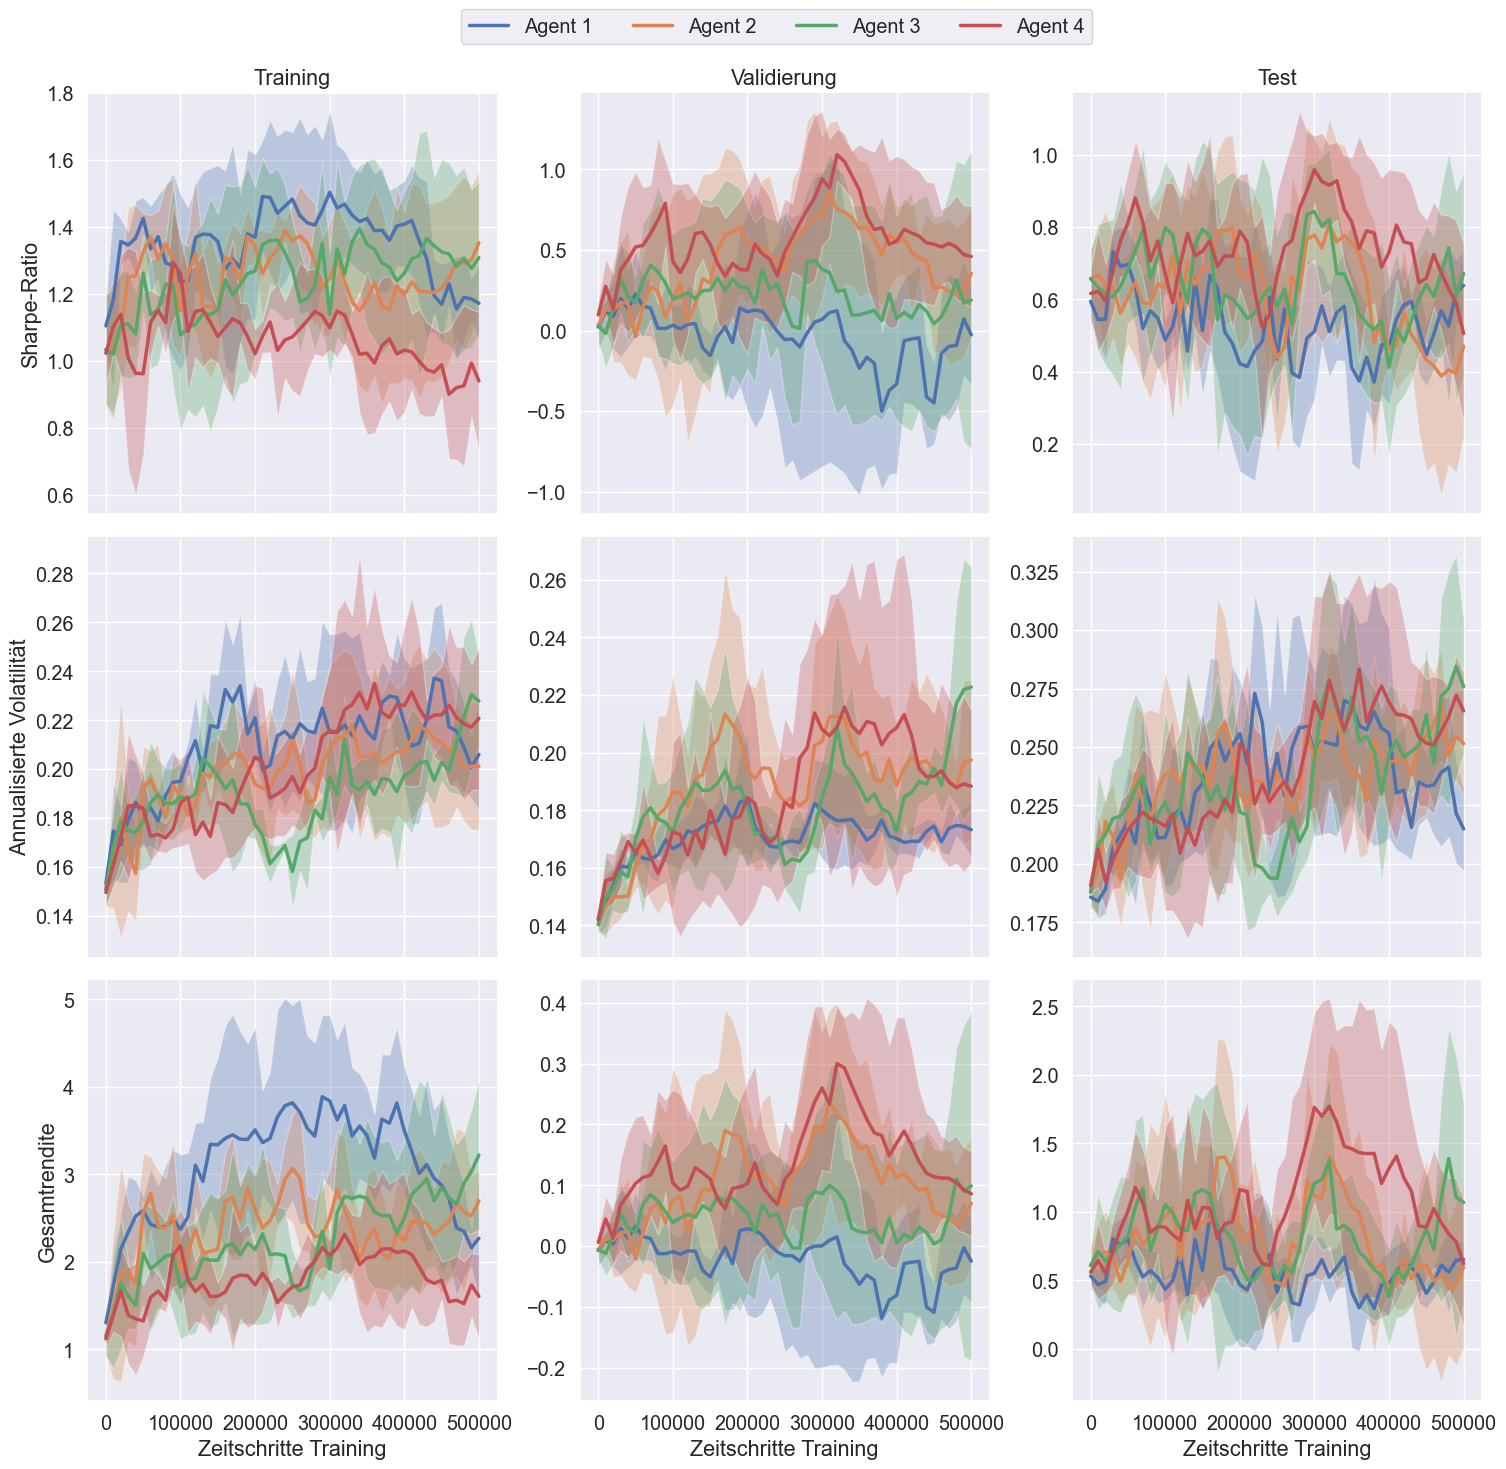

In [77]:
sns.set_theme()
sns.set_context('notebook', font_scale=1.3)  # Adjust the size of the text


# Create subplots (3 columns for the different datasets and 4 rows for the different measures)
fig, ax = plt.subplots(nrows = 3, ncols = 3,figsize = (18,17),sharex=True)

# Loop over the different measures
for row, df in enumerate([sharpe_ratios_envs,volatilities_envs,cumulative_returns_envs]):
    # Loop over the different datasets
    for col in range(3):
        # Loop over the different agents
        for agent_idx in range(4):
            mean = df.mean(axis=2)
            std = df.std(axis=2)
            ax[row][col].plot(
                            nums_saved_models,
                            mean[col][agent_idx], 
                            label=f'Agent {agent_idx+1}',
                            linewidth=2.5,
                            )
            
            
            ax[row][col].fill_between(
                            nums_saved_models, 
                            mean[col][agent_idx] - std[col][agent_idx], 
                            mean[col][agent_idx] + std[col][agent_idx], 
                            alpha=0.3
                            )

        # Adjust the xlabel at the bottom
        if row == 2:
            ax[row][col].set_xlabel('Zeitschritte Training')

        # Display only once the legend
        if row == 0 and col == 0:
            ax[row][col].legend(loc='upper center', bbox_to_anchor=(1.68, 1.22),ncols=9)
        else:
            continue
        


# Adjust the title on the y-axes
ax[0][0].set_ylabel('Sharpe-Ratio')
ax[1][0].set_ylabel('Annualisierte Volatilität')
ax[2][0].set_ylabel('Gesamtrendite')
#ax[3][0].set_ylabel('Episodische Belohnung (undiskontiert)')

# Adjust the titles on the x-axes
ax[0][0].set_title('Training')
ax[0][1].set_title('Validierung')
ax[0][2].set_title('Test')

# Adjust the height between subplots
plt.subplots_adjust(hspace=0.05)

## Extra (Display the architecture of the neural networks of the fourth agent)

Get the ANNs of the Recurrent PPO Agent

In [78]:
agnt = RecurrentPPO.load('/Applications/Studium/Master/Masterarbeit/AADRL/train_agents/training_eval/agent_4_seed_42/best_model.zip')

In [79]:
agnt.policy

# Note that the order does not match the one used in the algorithm ! # 
# 1) Feature Extractor, 2) LSTM 3) MLP Extractor 4 ) Action & Value Net 

RecurrentActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=30, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
  (lstm_actor): LSTM(212, 128)
  (lstm_critic): LSTM(212, 128)
)